## import libraries

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (5,3)

from scipy import stats
from ipywidgets import interact

from sklearn.svm import SVC
from sklearn.datasets import make_moons
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV


## create a plot function

In [19]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    """Plot the 2D-decision region of a classifier with matplotlib along its first two dimensions X[:,0] and X[:,1].

    Args:
        X (np.Array): (n,p) dataset to classify
        y (np.Array): (n,) array of labels. Works well up to 5 unique labels.
        classifier (sklearn): fitted sklearn classifier.
        test_idx (int, optional):  Index of test datapoints within X to display with a larger mark style. Defaults to None.
        resolution (float, optional): Resolution of the meshgrid used to colorize regions. Defaults to 0.02.
    """

    # setup marker generator and color map up for up to 5 classes
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plot samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx),
                    marker='x', label=cl)

    # Plot test samples if they exist
    if not test_idx is None:
        X_test, y_test = X[test_idx, :], y[test_idx]
        for idx, cl in enumerate(np.unique(y_test)):
            plt.scatter(x=X_test[y_test == cl, 0], y=X_test[y_test == cl, 1],
                        alpha=1, color=cmap(idx),
                        linewidths=1, marker='o', s=55, label=f'test {cl}')
    plt.legend()



## create XOR dataset

In [23]:
# what is XOR

np.logical_xor([True, True, False], [True, False, False])

array([False,  True, False])

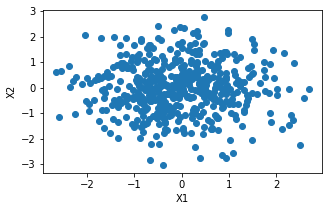

In [9]:
n = 500
noise = 0.2

# First, build our X1,X2 randomly from gaussian distributions
np.random.seed(0)
X = np.random.randn(n, 2)
plt.scatter(X[:,0], X[:,1])
plt.xlabel("X1")
plt.ylabel("X2");

In [10]:
# Then, build our binary class y 
# where y=1 if and only if (X1 > ε xor X2 > ε)
# epsilon ε not exactly zero to simulate "noise" 

x1 = X[:,0]
x2 = X[:,1]

epsilon = noise * np.random.randn(n, )

y_bool = np.logical_xor(
    x1 > epsilon, 
    x2 > epsilon
)
y = np.where(y_bool, 1, 0)

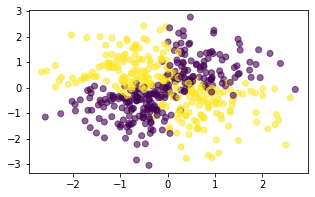

In [11]:
# We have re-created the XOR quadrant!
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.6)

## SVM kernels

kernel: a measure of "similarity" between points, which is used to classify points in SVM models (two points with large similarity would be classified similarly)

SVM kernels:
- Linear
- Polynomial
- Radial Basis Fonction (rbf)
- Sigmoid

### linear

In [12]:
svc = SVC(kernel = 'linear',C = 1) 
# C is the cost associated with wrong classification
svc.fit(X,y)
svc.score(X,y)

0.586

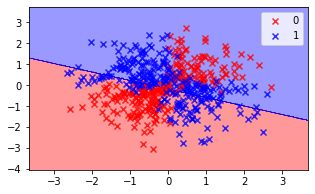

In [20]:
plot_decision_regions(X,y,svc)

In [14]:
log = LogisticRegression()
log.fit(X,y)
log.score(X,y)

0.528

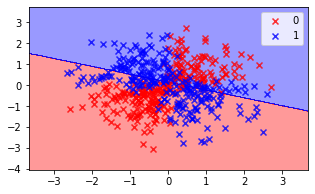

In [21]:
plot_decision_regions(X,y,log)

### poly

instead of measuring similarity by how close the points are in terms of dot product ("cosine similarity") for the linear kernel, we are measuring similarity based on **whether points are within a circle to each other or not.** 

In [18]:
poly = SVC(kernel='poly',C=100,degree=2)
poly.fit(X,y)
poly.score(X,y)

0.882

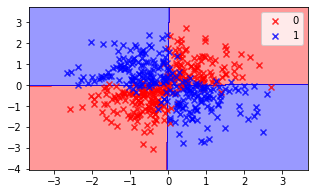

In [22]:
plot_decision_regions(X,y,poly)

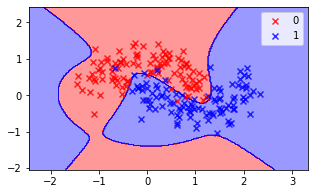

In [38]:
# Choose your degree
degree = 4

equivalent_polynomial_model = make_pipeline(
    (PolynomialFeatures(degree=degree)),  # First, create all polynomial combinations of your features
    (SVC(kernel="linear", C=100))  # Then, fit a linear SVM
)
equivalent_polynomial_model.fit(X, y)
plot_decision_regions(X, y, classifier=equivalent_polynomial_model)

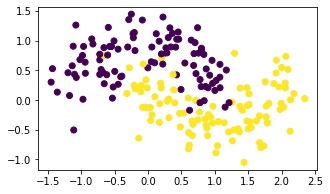

In [37]:
# import moons dataset

n=200
X,y = make_moons(n_samples=n, noise=0.25, random_state=0)
plt.scatter(X[:,0], X[:,1], c=y);

In [40]:
# interact 

@interact(C=[1, 10, 1000, 10000, 100000], degree=[1,2,3,4,5,6,7,8,9], coef0=[0,0.5,1,2,5,10,100])
def svc(C, degree, coef0):
    svm = SVC(kernel='poly', C=C, coef0=coef0, degree=degree)
    svm.fit(X, y)
    plot_decision_regions(X, y, classifier=svm)

interactive(children=(Dropdown(description='C', options=(1, 10, 1000, 10000, 100000), value=1), Dropdown(descr…

### rbf

gamma  𝛾
  reduces each instance’s range of influence on the others (myopia). Stronger  𝛾
 values will make your model overfit by looking "too closely" at small-scale irregularities

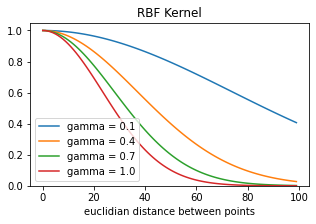

In [41]:
for gamma in np.linspace(0.1, 1, 4):
    plt.plot(np.exp(-gamma*np.linspace(0, 3, 100)**2),
             label=f'gamma = {gamma}')
plt.ylim(0,)
plt.title('RBF Kernel')
plt.xlabel('euclidian distance between points')
plt.legend();

In [43]:
rbf = SVC(kernel='rbf',C=1,gamma=1)
rbf.fit(X,y)
rbf.score(X,y)

0.94

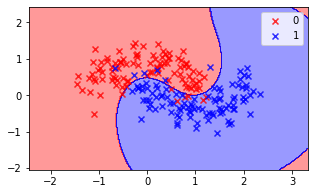

In [44]:
plot_decision_regions(X,y,rbf)

In [45]:
@interact(C=[0.1, 1, 10, 100, 1000, 10000], gamma = [0.001, 0.01, 0.1, 1, 10])
def svc(C=1, gamma=1):
    svm = SVC(kernel='rbf', gamma=gamma, C=C)
    svm.fit(X, y)
    plot_decision_regions(X, y, classifier=svm)

interactive(children=(Dropdown(description='C', index=1, options=(0.1, 1, 10, 100, 1000, 10000), value=1), Dro…

### sigmoid

In [46]:
@interact(C=[0.1, 1, 10, 100, 1000, 10000], gamma = [0.001, 0.01, 0.1, 1, 10], coef0=0.)
def svc(C=1000, gamma=0.1, coef0=0):
    svm = SVC(kernel='sigmoid', gamma=gamma, C=C, coef0=coef0)
    svm.fit(X, y)
    plot_decision_regions(X, y, classifier=svm)

interactive(children=(Dropdown(description='C', index=4, options=(0.1, 1, 10, 100, 1000, 10000), value=1000), …

## RandomizedSearchCV

In [48]:
grid = {'kernel':['linear','poly','sigmoid','rbf'],
        'C':[0.01,0.1,1,10],
        'degree':[2,3,4,5],
        'gamma':[0.01,0.1,1,10]}

In [49]:
model = SVC()
search = RandomizedSearchCV(model,grid,scoring='r2',cv=5)
search.fit(X,y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'degree': [2, 3, 4, 5],
                                        'gamma': [0.01, 0.1, 1, 10],
                                        'kernel': ['linear', 'poly', 'sigmoid',
                                                   'rbf']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scorin

In [50]:
search.best_params_

{'kernel': 'rbf', 'gamma': 10, 'degree': 3, 'C': 0.01}

In [51]:
best_model = SVC(kernel='rbf',gamma=10,degree=3,C=0.01)

In [52]:
best_model.fit(X,y)

SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

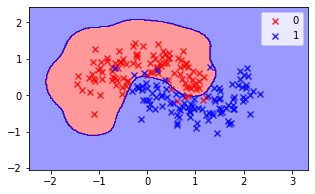

In [53]:
plot_decision_regions(X,y,best_model)

In [55]:
cv_results = cross_validate(best_model,X,y,cv=5,scoring=['accuracy'])
cv_results

{'fit_time': array([0.00299096, 0.00295281, 0.00233102, 0.00225115, 0.00153494]),
 'score_time': array([0.00138116, 0.00110722, 0.00099993, 0.00117588, 0.00060511]),
 'test_accuracy': array([0.975, 0.925, 0.9  , 0.9  , 0.975])}

In [56]:
cv_results['test_accuracy'].mean()

0.9349999999999999

## GridSearchCV

In [58]:
neigh = KNeighborsClassifier()
grid = {'n_neighbors':[1,5,10,20,50]}

search = GridSearchCV(neigh,grid,cv=5)
search.fit(X,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 5, 10, 20, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [59]:
search.best_params_

{'n_neighbors': 20}

In [60]:
best_neigh = KNeighborsClassifier(n_neighbors=20)
best_neigh.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

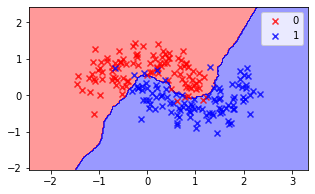

In [61]:
plot_decision_regions(X,y,best_neigh)